## End of distribution imputation

In the previous notebook we replaced missing data by an arbitrary value. However, determining the value of the arbitrary value can be laborious and it is usually a manual job. We can automate this process by automatically selecting arbitrary values at the end of the variable distributions.

#### How do we select the value at the end?

- If the variable is normally distributed, we can use the mean plus or minus 3 times the standard deviation
- If the variable is skewed, we can use the IQR proximity rule

We learnt these techniques in section 3, in  the lecture on "Outliers".

- We can also select the min / max value and multiply it by a certain amount of times, like 2 or 3.


### Which variables can I impute with an arbitrary value?

This method is suitable for numerical variables.

### Assumptions

- MNAR - values are not missing at random

If the value is not missing at random, we don't want to replace it for the mean / median and therefore make that observation look like the majority of our observations. Instead, we want to flag that observation as different, and therefore we assign a value that is at the tail of the distribution, where observations are rarely represented in the population.


### Advantages

- Easy to implement
- Fast way of obtaining complete datasets
- Can be integrated in production (during model deployment)
- Captures the importance of "missingess" if there is one

### Disadvantages

- Distortion of the original variable distribution
- Distortion of the original variance
- Distortion of the covariance with the remaining variables of the dataset
- This technique may mask true outliers in the distribution


### Final note

I haven't seen this method used in data competitions, however, this method is used in finance companies. When capturing the financial history of customers, in order not to assume that missing is at random, the missing data are replaced by a value at the end of the distribution.

See my [talk at PyData London in 2017](https://www.youtube.com/watch?v=KHGGlozsRtA) for an example of feature engineering in Finance.

## In this demo:

We will learn how to perform arbitrary value imputation using pandas on the Ames House Price and Titanic Datasets.

- To download the datasets please refer to the lecture **Datasets** in **Section 1** of this course.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# to split the datasets
from sklearn.model_selection import train_test_split

In [2]:
# load the Titanic Dataset with a few variables for demonstration

data = pd.read_csv('../Datasets/titanic.csv', usecols=['age', 'fare', 'survived'])
data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [6]:
# let's look at the percentage of NA

data.isnull().mean()

survived    0.000000
age         0.200917
fare        0.000764
dtype: float64

### Imputation important

Imputation has to be done over the training set, and then propagated to the test set. For this imputation technique, this means that when selecting the value with which we will replace the NA, we need to do so only by looking at the distribution of the variables in the training set. Then we use the selected value to replace NA both in the train and test set.

In [7]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((916, 2), (393, 2))

<AxesSubplot:>

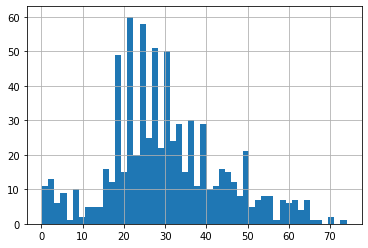

In [8]:
# let's have a look at the distribution of Ages
X_train.age.hist(bins=50)

In [9]:
# let's make a function to fill missing values with an extreme value:
# the variable takes the dataframe, the variable, and the value to replace na

# and returns the variable with the filled na

def impute_na(df, variable, value):

    return df[variable].fillna(value)

In [10]:
# far end of the distribution:

# Because Age looks approximately Gaussian, I use the
# mean and std to calculate the replacement value

X_train.age.mean() + 3 * X_train.age.std()

72.03416424092518

In [11]:
# replace NA with the value calculated above

X_train['Age_imputed'] = impute_na(X_train, 'age',
                                   X_train.age.mean() + 3 * X_train.age.std())

X_train.head(15)

,age,fare,Age_imputed
501,13.0,19.5000,13.000000
588,4.0,23.0000,4.000000
402,30.0,13.8583,30.000000
1193,NaN,7.7250,72.034164
686,22.0,7.7250,22.000000
971,NaN,7.8792,72.034164
117,30.0,56.9292,30.000000
540,2.0,26.0000,2.000000
294,49.0,110.8833,49.000000
261,35.0,26.2875,35.000000


Look at the rows with missing data (NaN) in Age, and see how in the new variable they were replaced by 73.436.

In [12]:
# we can see a change in the variance after end of tail imputation
# this is expected, because the percentage of missing data is quite
# high in Age ~20%

print('Original variable variance: ', X_train['age'].var())
print('Variance after 99 imputation: ', X_train['Age_imputed'].var())

Original variable variance:  194.16304666581854
Variance after 99 imputation:  427.39198372523583


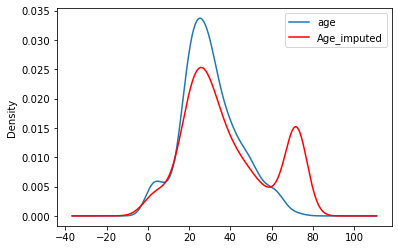

In [13]:
# we can see that the distribution has changed 
# with now more values accumulating towards the tail

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['age'].plot(kind='kde', ax=ax)

# imputed variable
X_train['Age_imputed'].plot(kind='kde', ax=ax, color='red')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

As mentioned above, similarly to arbitrary value imputation, end of tail imputation distorts the original distribution of the variable Age. The transformed variable shows more values around selected tail value.

**Is this important?**

It depends on the machine learning model you want to build. Linear models assume that the variables are normally distributed. End of tail imputation may distort the original normal distribution if the % of missing data is high. Therefore the final imputed variable will no longer be normally distributed, which in turn may affect the linear model performance.

On the other hand, this technique works quite well with tree based algorithms.

In [14]:
# we also said end of tail imputation may affect the relationship 
# with the other variables in the dataset, let's have a look

X_train[['fare', 'age', 'Age_imputed']].cov()

,fare,age,Age_imputed
fare,2248.326729,136.176223,19.647139
age,136.176223,194.163047,194.163047
Age_imputed,19.647139,194.163047,427.391984


We see indeed that the covariance between Age and Fare is changed after the arbitrary value imputation.

<AxesSubplot:>

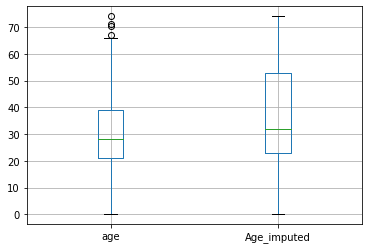

In [15]:
# Finally, I mentioned that end tail imputation may
# affect the perception of outliers

# Let's find out using a boxplot
X_train[['age', 'Age_imputed']].boxplot()

Masks the outliers!!

## House Prices Dataset

Let's repeat the exercise in the House Prices dataset. In this dataset, there are variables with a lot or few missing data. Therefore we can compare the effect of end tail imputation in both scenarios.

In [16]:
# we are going to use only the following variables,
# 3 of which contain NA

cols_to_use = [
    'OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'WoodDeckSF',
    'BsmtUnfSF', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'SalePrice'
]

In [17]:
# let's load the House Prices dataset

data = pd.read_csv('../Datasets/houseprice.csv', usecols=cols_to_use)
print(data.shape)
data.head()

(1460, 10)


,LotFrontage,OverallQual,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,GarageYrBlt,WoodDeckSF,SalePrice
0,65.0,7,196.0,150,856,856,1710,2003.0,0,208500
1,80.0,6,0.0,284,1262,1262,1262,1976.0,298,181500
2,68.0,7,162.0,434,920,920,1786,2001.0,0,223500
3,60.0,7,0.0,540,756,961,1717,1998.0,0,140000
4,84.0,8,350.0,490,1145,1145,2198,2000.0,192,250000


In [18]:
# in the next list comprehension, I loop over all the columns 
# of the dataset and select those that contain missing data

[var for var in data.columns if data[var].isnull().sum()>0]

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [19]:
# find the percentage of missing data within those variables
# same code as we learnt in section 3 on variable characteristics

data[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].isnull().mean()

LotFrontage    0.177397
MasVnrArea     0.005479
GarageYrBlt    0.055479
dtype: float64

In [20]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data,
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((1022, 10), (438, 10))

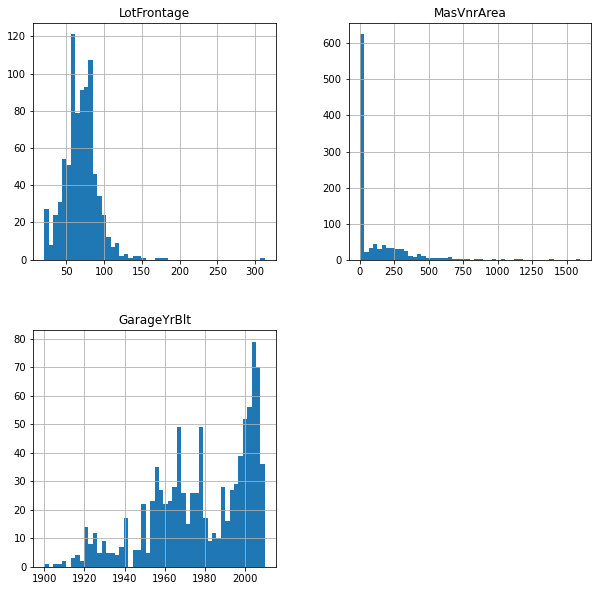

In [21]:
# let's plot the distributions of the variables
# we learnt this code in section 3 on variable characteristics

X_train[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].hist(bins=50, figsize=(10,10))
plt.show()

In [22]:
# the variables are not normally distributed

# let's impute the NA using the IQR proximity rule, which we learnt
# in the lecture on outliers in section 3

# calulate the IQR
IQR = X_train['LotFrontage'].quantile(0.75) - X_train['LotFrontage'].quantile(
    0.25)

# calculate the upper boundary
extreme_value = X_train['LotFrontage'].quantile(0.75) + 3 * IQR

extreme_value

146.0

In [27]:
# let's impute the NA with the extreme value

X_train.loc[:,'LotFrontage_imputed'] = impute_na(X_train, 'LotFrontage', extreme_value)
X_test.loc[:,'LotFrontage_imputed'] = impute_na(X_test, 'LotFrontage', extreme_value)

In [28]:
# let's do the same for MasVnrArea

# calculate the IQR
IQR = X_train['MasVnrArea'].quantile(0.75) - X_train['MasVnrArea'].quantile(
    0.25)

# calculate the upper boundary
extreme_value = X_train['MasVnrArea'].quantile(0.75) + 3 * IQR

extreme_value

680.0

In [25]:
# let's impute the NA with the extreme value

X_train.loc[:,'MasVnrArea_imputed'] = impute_na(X_train, 'MasVnrArea', extreme_value)
X_test.loc[:,'MasVnrArea_imputed'] = impute_na(X_test, 'MasVnrArea', extreme_value)

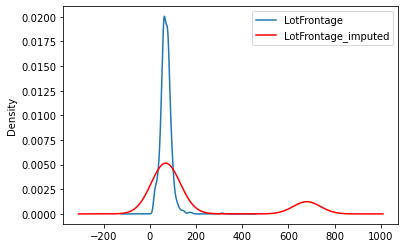

In [32]:
# let's evaluate the effect of end tail imputation on the distribution

# we can see that the distribution has changed for LotFrontAge
# with now more values accumulating towards the extreme value

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['LotFrontage'].plot(kind='kde', ax=ax)

# imputed variable
X_train['LotFrontage_imputed'].plot(kind='kde', ax=ax, color='red')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

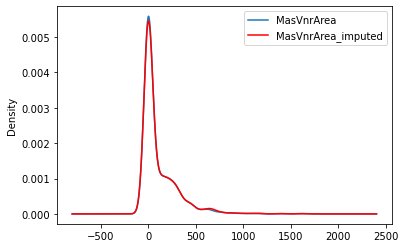

In [33]:
# let's evaluate the effect of arbitrary imputation on the distribution

# MasVnrArea had only few outliers, so the change in the distribution is
# not so dramatic. Less than when using an arbitrary value of 2999 as
# we did in the previous notebook

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['MasVnrArea'].plot(kind='kde', ax=ax)

# imputed variable
X_train['MasVnrArea_imputed'].plot(kind='kde', ax=ax, color='red')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

From the above plots we can see that the distribution of LotFrontAge is changed quite dramatically, but not so much the distribution of MasVnrArea. This is because the % of missing values in the second variable is quite small.

<AxesSubplot:>

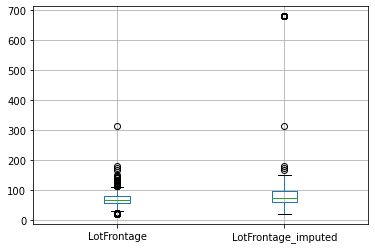

In [34]:
# we see that there are a fewer outliers as well after the imputation

X_train[['LotFrontage', 'LotFrontage_imputed']].boxplot()

<AxesSubplot:>

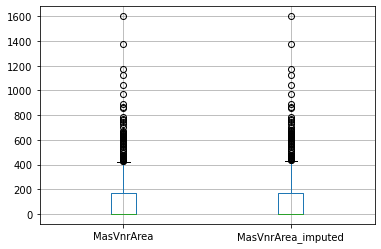

In [35]:
# however, the outliers are not so affected for MasVnrArea

X_train[['MasVnrArea', 'MasVnrArea_imputed']].boxplot()

In [36]:
# similarly we can explore the effect of the imputation technique on 
# the variance

# we can see a change in the variance after imputation for LotFrontAge
# this is expected, because the percentage of missing data is quite
# high ~20%

print('Original Variance: ', X_train['LotFrontage'].var())
print('Variance after imputation: ', X_train['LotFrontage_imputed'].var())

Original Variance:  532.5872021885676
Variance after imputation:  56637.2576020976


In [37]:
# the same for MasnVnrArea is not so big
# Note particularly, that this effect is smaller than the one we observed
# when imputing by 2999 in the previous notebook!!!

print('Original Variance: ', X_train['MasVnrArea'].var())
print('Variance after imputation: ', X_train['MasVnrArea_imputed'].var())

Original Variance:  32983.538710039466
Variance after imputation:  34441.33126074531


In [40]:
# finally, let's explore the covariance:
# take your time to compare the values in the table below.

X_train.cov()

,LotFrontage,OverallQual,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,GarageYrBlt,WoodDeckSF,SalePrice,LotFrontage_imputed,MasVnrArea_imputed
LotFrontage,532.587202,6.587119,6.805603e+02,9.496573e+02,2.908856e+03,3.379794e+03,3.919952e+03,30.611717,1.347414e+02,6.689645e+05,532.587202,6.934872e+02
OverallQual,6.587119,1.843859,1.014970e+02,1.746147e+02,2.886241e+02,2.242973e+02,4.091242e+02,17.902809,3.168557e+01,8.320132e+04,-10.162185,1.035991e+02
MasVnrArea,680.560330,101.496976,3.298354e+04,7.540788e+03,2.478877e+04,2.086595e+04,3.520785e+04,1203.583792,3.208924e+03,6.836439e+06,1229.825182,3.298354e+04
BsmtUnfSF,949.657293,174.614725,7.540788e+03,1.875241e+05,7.513307e+04,4.987449e+04,5.203392e+04,1823.065167,-1.833201e+03,6.833028e+06,-12216.163266,7.680598e+03
TotalBsmtSF,2908.855504,288.624075,2.478877e+04,7.513307e+04,1.682931e+05,1.212079e+05,8.615192e+04,3173.042442,1.227966e+04,2.003928e+07,1877.873757,2.473980e+04
1stFlrSF,3379.793504,224.297266,2.086595e+04,4.987449e+04,1.212079e+05,1.398656e+05,1.044401e+05,2009.195552,1.109406e+04,1.783631e+07,5861.114434,2.055453e+04
GrLivArea,3919.951834,409.124216,3.520785e+04,5.203392e+04,8.615192e+04,1.044401e+05,2.681277e+05,2738.982988,1.558395e+04,2.934477e+07,7423.553496,3.541558e+04
GarageYrBlt,30.611717,17.902809,1.203584e+03,1.823065e+03,3.173042e+03,2.009196e+03,2.738983e+03,624.305948,6.658911e+02,9.309355e+05,38.478352,1.274750e+03
WoodDeckSF,134.741376,31.685571,3.208924e+03,-1.833201e+03,1.227966e+04,1.109406e+04,1.558395e+04,665.891118,1.648582e+04,3.029981e+06,3569.095262,3.088048e+03
SalePrice,668964.454191,83201.317781,6.836439e+06,6.833028e+06,2.003928e+07,1.783631e+07,2.934477e+07,930935.489321,3.029981e+06,6.105731e+09,811514.141107,6.872641e+06


**That is all for this demonstration. I hope you enjoyed the notebook, and see you in the next one.**